In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import warnings

sns.set()
rcParams['figure.figsize'] = (20,10)
pd.options.display.max_columns = None
warnings.filterwarnings('ignore')

In [ ]:
import re
from underthesea import word_tokenize

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_ds, test_ds = [], []
with open('../data/raw_train/neg.txt') as f:
    for line in f.readlines():
        train_ds.append((line.lower().strip(), 'NEG'))
    
with open('../data/raw_train/pos.txt') as f:
    for line in f.readlines():
        train_ds.append((line.lower().strip(), 'POS'))

with open('../data/raw_train/neu.txt') as f:
    for line in f.readlines():
        train_ds.append((line.lower().strip(), 'NEU'))

with open('../data/raw_test/test.txt') as f:
    total_lines = f.readlines()
    for i in range(0, len(total_lines), 2):
        test_ds.append((total_lines[i].lower().strip(), total_lines[i+1].strip()))
    
# convert to dataframe
train_df = pd.DataFrame(train_ds, columns=['text', 'label'])
test_df = pd.DataFrame(test_ds, columns=['text', 'label'])

In [ ]:
# take only rows with text length > 0
train_df = train_df[train_df['text'].apply(lambda x: len(x) > 0)]
test_df = test_df[test_df['text'].apply(lambda x: len(x) > 0)]

In [ ]:
train_df.head()

In [ ]:
def preprocessing(df, stopwords=None, min_word_count=3):
    # remove url
    
    df['text'] = df['text'].apply(lambda x: word_tokenize(x, format='text'))
    
    def func(text):
      text = re.sub(r'\bhttps?:\/\/\S+\b', '', text)
      text = re.sub(r'[^\s\wáàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệóòỏõọôốồổỗộơớờởỡợíìỉĩịúùủũụưứừửữựýỳỷỹỵđ_.,!?]','',text)
      text = re.sub(r'\s+', ' ', text).strip()
      text = re.sub(r"\b\d+(\.\d+)+\b", "<<version>>", text)
      text = re.sub(r'\b\d+\b', '<<num>>', text)
      text = re.sub(r"\b\w*\d+\w*\b", "<<special1>>", text)

      return text
    df['text'] = df['text'].apply(func)

    # remove stopwords in text
    if stopwords is not None:
        df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords]))

    # take only texts with more than min_word_count words
    df = df[df['text'].apply(lambda x: len(x.split()) >= min_word_count)]

    df.reset_index(drop=True, inplace=True)
    return df

In [ ]:
train_df = preprocessing(train_df)
test_df = preprocessing(test_df)

In [ ]:
train_df.to_csv('../data/clean/train.csv', index=False)
test_df.to_csv('../data/clean/test.csv', index=False)

In [ ]:
train_df.head()

In [6]:
train_df = pd.read_csv('../data/clean/train.csv')
test_df = pd.read_csv('../data/clean/test.csv')

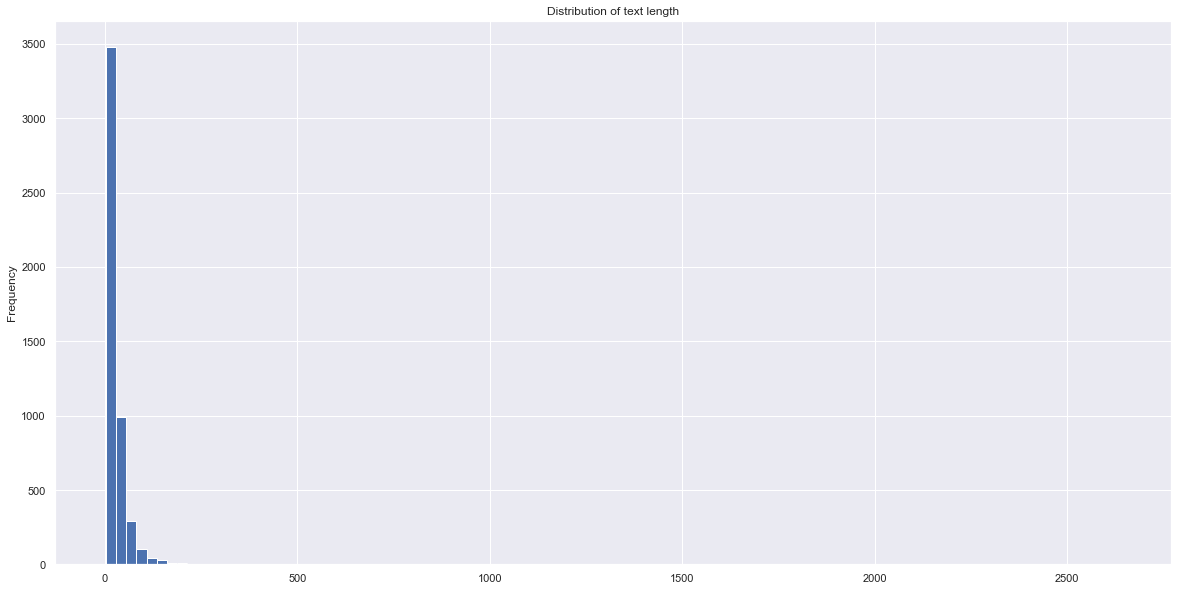

In [27]:
# display text length distribution
plt.figure(figsize=(20, 10))
train_df['text'].apply(lambda x: len(x.split())).plot.hist(bins=100)
plt.title('Distribution of text length')
plt.show()

In [28]:
# describe text length
train_df['text'].apply(lambda x: len(x.split())).describe()

count    4983.000000
mean       29.529199
std        63.641089
min         3.000000
25%        11.000000
50%        19.000000
75%        34.000000
max      2638.000000
Name: text, dtype: float64

In [7]:
word_count = {}
for text in train_df['text']:
    for word in text.split():
        if word == '<num>': continue
        word_count[word] = word_count.get(word, 0) + 1
word_count_df = pd.DataFrame(word_count.items(), columns=['word', 'count'])
word_count_df.sort_values('count', ascending=False, inplace=True)

In [8]:
word_count_df.head()

,word,count
15,.,5800
6,",",5630
65,<<num>>,4728
8,là,2101
17,thì,1913


In [11]:
vocab = word_count_df[word_count_df['count'] >= 5]['word'].values
len(vocab)

2228

In [29]:
word2idx = {word: idx for idx, word in enumerate(vocab, 2)}
word2idx['<pad>'] = 0
word2idx['<unk>'] = 1

label2idx = {'POS': 0, 'NEG': 1, 'NEU': 2}

In [120]:
class TextDataset(Dataset):
    def __init__(self, train_df, test_df, word2idx, cur_set='train', max_len=100):
        self.word2idx = word2idx
        train, val = train_test_split(train_df, test_size=0.15, random_state=42)
        self.lookup = {
            'train': train.reset_index(drop=True).copy(),
            'val': val.reset_index(drop=True).copy(),
            'test': test_df.reset_index(drop=True).copy()
        }
        self.cur_set = cur_set
        self.max_len = max_len
    
    def __len__(self):
        return len(self.lookup[self.cur_set])
    
    def __getitem__(self, idx):
        text, label = self.lookup[self.cur_set].iloc[idx]
        X = [self.word2idx.get(word, self.word2idx['<unk>']) for word in text.split()]
        X = X[:self.max_len]
        if len(X) < self.max_len:
            X = X + [self.word2idx['<pad>']] * (self.max_len - len(X))
        X = torch.tensor(X).to(device)
        label = torch.tensor(label2idx[label]).to(device)
        return X, label
    
    def get_dl(self, batch_size, shuffle=True, drop_last=True, cur_set='train'):
        self.cur_set = cur_set
        return DataLoader(self, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last)

### Model

In [121]:
class Classifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_classes, n_feature_maps=100, hidden_dim=256):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        self.convs = nn.ModuleList([
            nn.Conv1d(embedding_dim, n_feature_maps, kernel_size=3, padding=1),
            nn.Conv1d(embedding_dim, n_feature_maps, kernel_size=4, padding=1),
            nn.Conv1d(embedding_dim, n_feature_maps, kernel_size=5, padding=1),
            nn.Conv1d(embedding_dim, n_feature_maps, kernel_size=6, padding=1)
        ])

        self.ff = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(n_feature_maps*4, hidden_dim),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(0, 2, 1)

        temp = []
        for conv in self.convs:
            x_temp = conv(x)
            x_temp = F.max_pool1d(x_temp, x_temp.shape[2]).squeeze(2)
            temp.append(x_temp)

        x = self.ff(torch.cat(temp, dim=1))
        return x

In [122]:
dataset = TextDataset(train_df, test_df, word2idx)

In [123]:
model = Classifier(len(word2idx), 300, 3).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [124]:
# test model with one batch
with torch.no_grad():
    for X, y in dataset.get_dl(32, cur_set='train'):
        print(X.shape, y.shape)
        print(model(X).shape)
        break

torch.Size([32, 100]) torch.Size([32])
torch.Size([32, 3])


In [125]:
# train model
def train(model, dataset, loss_fn, optimizer, epochs=10, batch_size=32):
    for epoch in range(epochs):
        model.train()
        train_dl = dataset.get_dl(batch_size, cur_set='train')
        losses, accs = [], []
        for X, y in tqdm(train_dl):
            optimizer.zero_grad()
            out = model(X)
            loss = loss_fn(out, y)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            accs.append((out.argmax(1) == y).float().mean().item())

        model.eval()
        val_losses, val_accs = [], []
        with torch.no_grad():
            val_dl = dataset.get_dl(batch_size, cur_set='val')
            val_losses, val_accs = [], []
            for X, y in tqdm(val_dl):
                out = model(X)
                loss = loss_fn(out, y)
                val_losses.append(loss.item())
                val_accs.append((out.argmax(1) == y).float().mean().item())

        print(f'Epoch: {epoch+1}/{epochs}, Train Loss: {np.mean(losses):.4f}, Train Acc: {np.mean(accs):.4f}, Val Loss: {np.mean(val_losses):.4f}, Val Acc: {np.mean(val_accs):.4f}')

# evaluate on test set
def evaluate(model, dataset, loss_fn, batch_size=32):
    model.eval()
    test_dl = dataset.get_dl(batch_size, cur_set='test')
    losses, accs = [], []
    with torch.no_grad():
        for X, y in tqdm(test_dl):
            out = model(X)
            loss = loss_fn(out, y)
            losses.append(loss.item())
            accs.append((out.argmax(1) == y).float().mean().item())
    print(f'Test Loss: {np.mean(losses):.4f}, Test Acc: {np.mean(accs):.4f}')

def predict(model, dataset, batch_size=32):
    model.eval()
    test_dl = dataset.get_dl(batch_size, cur_set='test', shuffle=False, drop_last=False)
    preds = []
    with torch.no_grad():
        for X, _ in tqdm(test_dl):
            out = model(X)
            preds.append(out.argmax(1).cpu().numpy())
    return np.concatenate(preds)


In [126]:
train(model, dataset, loss_fn, optimizer, epochs=5, batch_size=32)

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: 1/5, Train Loss: 1.0609, Train Acc: 0.4370, Val Loss: 1.0876, Val Acc: 0.4307


  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: 2/5, Train Loss: 0.8856, Train Acc: 0.5942, Val Loss: 0.8693, Val Acc: 0.6209


  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: 3/5, Train Loss: 0.7544, Train Acc: 0.6705, Val Loss: 0.8355, Val Acc: 0.6168


  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: 4/5, Train Loss: 0.6052, Train Acc: 0.7483, Val Loss: 0.8019, Val Acc: 0.6399


  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: 5/5, Train Loss: 0.4685, Train Acc: 0.8203, Val Loss: 0.8035, Val Acc: 0.6630


In [127]:
evaluate(model, dataset, loss_fn, batch_size=32)

  0%|          | 0/32 [00:00<?, ?it/s]

Test Loss: 0.8250, Test Acc: 0.6426


  0%|          | 0/33 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.76      0.59      0.67       342
           1       0.65      0.61      0.63       341
           2       0.57      0.73      0.64       350

    accuracy                           0.64      1033
   macro avg       0.66      0.64      0.64      1033
weighted avg       0.66      0.64      0.64      1033



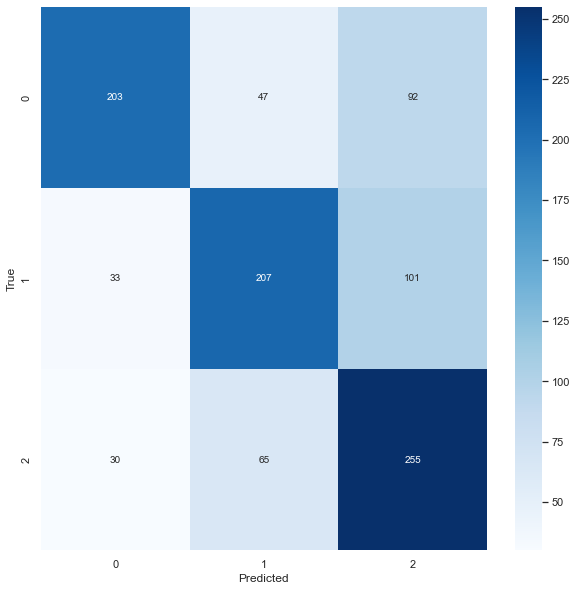

In [128]:
# plot confusion matrix
from sklearn.metrics import confusion_matrix, classification_report

preds = predict(model, dataset, batch_size=32)
print(classification_report(test_df['label'].map(label2idx), preds))
cm = confusion_matrix(test_df['label'].map(label2idx), preds)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [129]:
# save model
torch.save(model.state_dict(), '../models/model.pt')